In [2]:
!pip -q install torchinfo
!pip -q install torchview

In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from torchinfo import summary
from torchview import draw_graph

from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
import os
import glob

from sklearn.model_selection import train_test_split

from PIL import Image
from skimage import io
import cv2
from matplotlib import pyplot as plt
import numpy as np

from tqdm import tqdm

In [5]:
import kagglehub
path = kagglehub.dataset_download("andrewmvd/breast-cancer-cell-segmentation")

100%|██████████| 93.7M/93.7M [00:05<00:00, 19.0MB/s]

Extracting files...


# Helper Function

In [6]:
def test_model(model, x):
  preds = model(x)
  print(preds.shape)

  print("Input :", x.shape)
  print("Output :", preds.shape)

  # Modified assertion to check batch size and spatial dimensions, allowing channel dimension to differ
  assert preds.shape[0] == x.shape[0] and preds.shape[2:] == x.shape[2:]

In [7]:
def find_all_image_paths(directory_path):
    """
    Finds all image files in the given directory and its subdirectories.

    Supported formats:
    .png, .jpg, .jpeg, .bmp, .tiff, .tif, .webp, .gif

    Args:
        directory_path (str): The starting directory path.

    Returns:
        list: A list of paths to all image files found.
    """

    image_extensions = ('*.png', '*.jpg', '*.jpeg', '*.bmp',
                        '*.tiff', '*.tif', '*.webp', '*.gif')

    image_paths = []

    for ext in image_extensions:
        search_pattern = os.path.join(directory_path, '**', ext)
        image_paths.extend(glob.glob(search_pattern, recursive=True))
        search_pattern_upper = os.path.join(directory_path, '**', ext.upper())
        image_paths.extend(glob.glob(search_pattern_upper, recursive=True))

    return image_paths

In [8]:
def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    print("💾 Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("🚀 Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

In [9]:
def val_loss(loader, model, loss_fn, device="cuda"):
    model.eval()
    losses = []

    with torch.no_grad():
        for data, targets in loader:
            data = data.to(device)
            targets = targets.float().unsqueeze(1).to(device)

            predictions = model(data)
            loss = loss_fn(predictions, targets)
            losses.append(loss.item())

    model.train()
    return sum(losses) / len(losses)

In [10]:
# # Source - https://stackoverflow.com/a/71999355
# # Posted by KarelZe, modified by community. See post 'Timeline' for change history
# # Retrieved 2026-01-27, License - CC BY-SA 4.0

# class EarlyStopping:
#     def __init__(self, tolerance=5, min_delta=0):

#         self.tolerance = tolerance
#         self.min_delta = min_delta
#         self.counter = 0
#         self.early_stop = False

#     def __call__(self, train_loss, validation_loss):
#         if (validation_loss - train_loss) > self.min_delta:
#             self.counter +=1
#             if self.counter >= self.tolerance:
#                 self.early_stop = True

import copy

class EarlyStopping:
    def __init__(self, patience=5, delta=0.0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = copy.deepcopy(model.state_dict())

        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.best_model_state = copy.deepcopy(model.state_dict())
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)


In [11]:
def get_tiff_image(path, normalized=False):
    image = io.imread(path)
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if normalized:
        return image/255
    return image

# UNet with attention

In [12]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            # 1st Conv layer
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False), # bias is false becouse we use batch norm
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),

            # 2nd Conv layer
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)


class AttentionGate(nn.Module):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionGate, self).__init__()

        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1, stride=1, padding=0, bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, g, x):
        """
        g: decoder feature (gating signal)
        x: encoder feature (skip connection)
        """
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.psi(psi)

        return x * psi


class AttentionUNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(AttentionUNet, self).__init__()

        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.attentions = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Encoder
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Bottleneck
        self.bottleneck = DoubleConv(features[-1], features[-1]*2)

        # Decoder + Attention
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2,
                    feature,
                    kernel_size=2,
                    stride=2
                )
            )

            self.attentions.append(
                AttentionGate(
                    F_g=feature,
                    F_l=feature,
                    F_int=feature // 2
                )
            )

            self.ups.append(DoubleConv(feature * 2, feature))

        # Final output
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Encoder
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Decoder with attention
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)

            skip = skip_connections[idx // 2]

            if x.shape != skip.shape:
                x = F.interpolate(x, size=skip.shape[2:], mode="bilinear", align_corners=False)

            # Attention applied here
            skip = self.attentions[idx // 2](g=x, x=skip)

            x = torch.cat((skip, x), dim=1)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)

In [13]:
model = AttentionUNet(in_channels=3, out_channels=1)

summary(model, input_size=(1, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
AttentionUNet                            [1, 1, 256, 256]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-1                   [1, 64, 256, 256]         --
│    │    └─Sequential: 3-1              [1, 64, 256, 256]         38,848
├─MaxPool2d: 1-2                         [1, 64, 128, 128]         --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-2                   [1, 128, 128, 128]        --
│    │    └─Sequential: 3-2              [1, 128, 128, 128]        221,696
├─MaxPool2d: 1-4                         [1, 128, 64, 64]          --
├─ModuleList: 1-7                        --                        (recursive)
│    └─DoubleConv: 2-3                   [1, 256, 64, 64]          --
│    │    └─Sequential: 3-3              [1, 256, 64, 64]          885,760
├─MaxPool2d: 1-6                         [1,

In [14]:
# model_graph = draw_graph(model, input_size=(1, 3, 256, 256), expand_nested=True)
# model_graph.visual_graph

# Hyper parameters

In [102]:
# Traning Config
LEARNING_RATE = 2e-4
# LEARNING_RATE = 1e-4 # Reduced learning rate for stability
NUM_EPOCHS = 200
NUM_WORKERS = 2
# MOMENTUM = 0.5

# Batch size
TRANING_BATCH_SIZE = 8
VAL_BATCH_SIZE = 8
TEST_BATCH_SIZE = 8

# Image Config
IMAGE_HEIGHT = 512
IMAGE_WIDTH = 512
CHANNELS_IMG = 3

# Early stoping
PATIENCE = 5
MINI_DELTA = 1e-3

# Load and save model
LOAD_MODEL = False
SAVE_MODEL = True

CHECK_VALIDATION_LOSS = True

CHECKPOINT = "my_checkpoint.pth.tar"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

TRAIN_DATA_SHUFFLE = True
VAL_DATA_SHUFFLE = False

# DATASET_ROOT_DIR = "/kaggle/input/breast-cancer-cell-segmentation"
DATASET_ROOT_DIR = path

IMAGES_DIR = os.path.join(DATASET_ROOT_DIR, "Images")
MASKS_DIR = os.path.join(DATASET_ROOT_DIR, "Masks")

# Dataset Process pipeline

In [103]:
images = find_all_image_paths(IMAGES_DIR)
masks = find_all_image_paths(MASKS_DIR)

images.sort()
masks.sort()

dataset = []
for image, mask in zip(images, masks):
  dataset.append((image, mask))

train_paths, val_paths = train_test_split(dataset, test_size=0.2, random_state=42)

print(f"Train size: {len(train_paths)}")
print(f"Val size: {len(val_paths)}")

Train size: 46
Val size: 12


In [104]:
class SegmentationDataset(Dataset):
  def __init__(self, dataset, transform=None):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    img_path, mask_path = self.dataset[idx]
    image = get_tiff_image(img_path)
    mask = get_tiff_image(mask_path).astype(np.float32)
    mask[mask == 255.0] = 1.0 # Uncommented this line to normalize masks

    if self.transform is not None:
      argumentation = self.transform(image=image, mask=mask)
      image = argumentation["image"]
      mask = argumentation["mask"]

    return image, mask

Image shape: (768, 896, 3)
Mask shape: (768, 896)

Image dtype: uint8
Mask dtype: float32

Image min: 30 | Image max: 255
Mask min: 0.0 | Mask max: 1.0



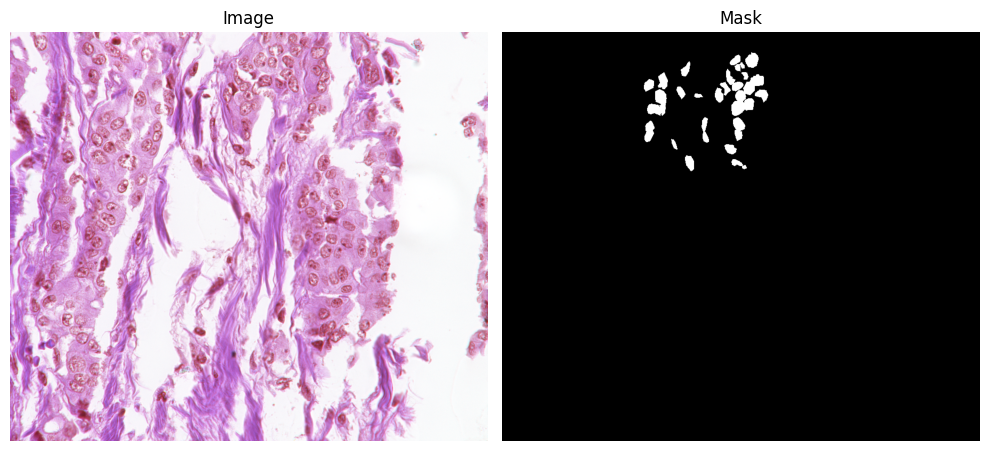

In [105]:
test_data = SegmentationDataset(dataset)

img = test_data[23]

print(f"Image shape: {img[0].shape}")
print(f"Mask shape: {img[1].shape}\n")

print(f"Image dtype: {img[0].dtype}")
print(f"Mask dtype: {img[1].dtype}\n")

print(f"Image min: {img[0].min()}", "|", f"Image max: {img[0].max()}")
print(f"Mask min: {img[1].min()}", "|", f"Mask max: {img[1].max()}\n")

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img[0])
ax[0].set_title("Image")
ax[0].set_axis_off()

ax[1].imshow(img[1], cmap="gray")
ax[1].set_title("Mask")
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

In [106]:
train_transform = A.Compose(
    [
      A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
      A.Rotate(limit=35, p=1.0),
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.1),
      A.Normalize(
          mean=[0.0, 0.0, 0.0],
          std=[1.0, 1.0, 1.0],
          max_pixel_value=255.0,
      ),
      ToTensorV2(),
    ],
)

In [107]:
# Load Dataset
train_dataset = SegmentationDataset(train_paths, transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=TRANING_BATCH_SIZE, shuffle=TRAIN_DATA_SHUFFLE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f"Train batch size: {len(train_dataloader)}")
print(f"Train batch shape: {next(iter(train_dataloader))[0].shape}\n")

print(f"Image shape: {next(iter(train_dataloader))[0][0].shape}")
print(f"Mask shape: {next(iter(train_dataloader))[1][0].shape}\n")

print(f"Image dtype: {next(iter(train_dataloader))[0].dtype}")
print(f"Mask dtype: {next(iter(train_dataloader))[1].dtype}\n")

print(f"Image min: {next(iter(train_dataloader))[0].min()}", "|", f"Image max: {next(iter(train_dataloader))[0].max()}")
print(f"Mask min: {next(iter(train_dataloader))[1].min()}", "|", f"Mask max: {next(iter(train_dataloader))[1].max()}\n")


Train batch size: 6
Train batch shape: torch.Size([8, 3, 512, 512])

Image shape: torch.Size([3, 512, 512])
Mask shape: torch.Size([512, 512])

Image dtype: torch.float32
Mask dtype: torch.float32

Image min: 0.0 | Image max: 1.0
Mask min: 0.0 | Mask max: 1.0



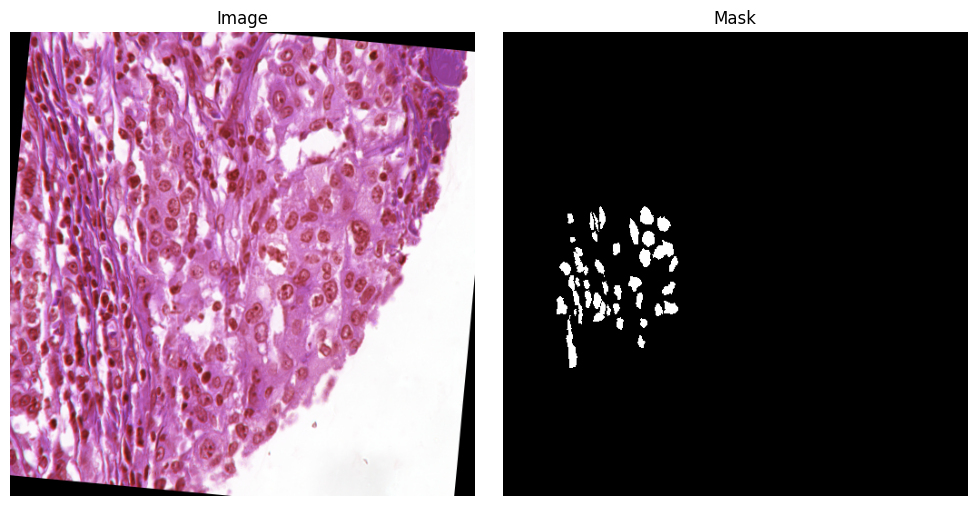

In [108]:
x, y = next(iter(train_dataloader))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(x[0].permute(1, 2, 0))
ax[0].set_title("Image")
ax[0].set_axis_off()

ax[1].imshow(y[0], cmap="gray")
ax[1].set_title("Mask")
ax[1].set_axis_off()

plt.tight_layout()
plt.show()

# Loss Function and Accuracy Matrix

In [109]:
# ---------------------------
# Dice Loss
# ---------------------------
def dice_loss(y_true, y_pred, smooth=1e-6):
    """
    y_true: (N, 1, H, W) or (N, H, W)
    y_pred: (N, 1, H, W) or (N, H, W) - probabilities (after sigmoid)
    """
    y_true = y_true.view(-1)
    y_pred = y_pred.view(-1)

    intersection = (y_true * y_pred).sum()
    dice = (2. * intersection + smooth) / (
        y_true.sum() + y_pred.sum() + smooth
    )

    return 1 - dice


# ---------------------------
# BCE + Dice Loss
# ---------------------------
def bce_dice_loss(y_true, y_pred):
    """
    Combines Binary Cross Entropy and Dice Loss
    """
    bce = F.binary_cross_entropy(y_pred, y_true)
    dsc = dice_loss(y_true, y_pred)
    return bce + dsc


# ---------------------------
# IoU Metric
# ---------------------------
def iou_metric(y_true, y_pred, smooth=1e-6):
    """
    Computes IoU score
    """
    y_pred = (y_pred > 0.5).float()

    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)
    return iou


# ---------------------------
# Standalone soft_iou_loss helper function
# ---------------------------
def soft_iou_loss(y_true, y_pred, smooth=1e-6):
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)

    intersection = (y_true_flat * y_pred_flat).sum()
    union = y_true_flat.sum() + y_pred_flat.sum() - intersection

    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou


class my_loss(nn.Module):
  def __init__(self):
    super(my_loss, self).__init__()
    # Instantiate BCEWithLogitsLoss in the constructor
    self.bce_loss = nn.BCEWithLogitsLoss()

  def forward(self, y_pred, y_true):
    # Calculate BCE loss
    bce = self.bce_loss(y_pred, y_true)

    # Apply sigmoid to predictions before calculating soft IoU loss
    predictions_sigmoid = torch.sigmoid(y_pred)
    iou_l = soft_iou_loss(y_true, predictions_sigmoid)
    dice = dice_loss(y_true, predictions_sigmoid)

    # return bce + iou_l
    # return bce + dice
    return bce + iou_l + dice

# Tranning Pipeline

In [110]:
def traning_fn(loader, model, optimizer, loss_fn, scaler):
  model.train()
  loop = tqdm(loader)
  running_loss = 0.0

  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    # Forward pass
    with torch.amp.autocast(device_type=DEVICE):
      predictions = model(data)
      loss = loss_fn(predictions, targets)

    # Backward pass
    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # Update tqdm loop
    running_loss += loss.item()
    loop.set_postfix(loss=loss.item())

  return running_loss / len(loader)

In [111]:
def main():
  train_transform = A.Compose(
      [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
      ],
  )

  val_transform = A.Compose(
      [
        A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
      ],
  )

  # model = UNet(in_channels=3, out_channels=1).to(DEVICE)
  model = AttentionUNet(in_channels=3, out_channels=1).to(DEVICE)

  loss_fn = my_loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
  scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)

  # loss_fn = nn.BCEWithLogitsLoss()
  # optimizer = torch.optim.SGD(model.parameters(), lr=0.02, momentum=0.5)

  # early_stopping = EarlyStopping(tolerance=4, min_delta=10)
  early_stopping = EarlyStopping(patience=PATIENCE, delta=MINI_DELTA)

  # Load Dataset
  train_dataset = SegmentationDataset(train_paths, transform=train_transform)
  train_dataloader = DataLoader(train_dataset, batch_size=TRANING_BATCH_SIZE, shuffle=TRAIN_DATA_SHUFFLE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

  val_dataset = SegmentationDataset(val_paths, transform=val_transform)
  val_dataloader = DataLoader(val_dataset, batch_size=VAL_BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

  print(f"Train batch size: {len(train_dataloader)}")
  print(f"Val batch size: {len(val_dataloader)}")
  # print(f"Test batch size: {len(test_dataloader)}\n")

  # Load model
  if LOAD_MODEL:
    load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

  # Requred Variable
  scaler = torch.amp.GradScaler(device=DEVICE)

  train_loss_list = []
  validation_loss_list = []

  # Traning Loop
  for epoch in range(NUM_EPOCHS):
    # Train Model
    train_loss = traning_fn(train_dataloader, model, optimizer, loss_fn, scaler)

    print()
    print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}")
    print(f"Train loss: {train_loss}")

    # Save Model
    if SAVE_MODEL and epoch % 2 == 0:
      checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
      }
      save_checkpoint(checkpoint, CHECKPOINT)

    # early stopping
    # early_stopping(train_loss, validation_loss)
    # if early_stopping.early_stop:
    #   print("We are at epoch:", epoch)
    #   break

    # Update traing and validation loss
    train_loss_list.append(train_loss)

    # Check Validation
    if CHECK_VALIDATION_LOSS:
      validation_loss = val_loss(val_dataloader, model, loss_fn, device=DEVICE)
      print(f"Validation loss: {validation_loss}")
      early_stopping(validation_loss, model)
      validation_loss_list.append(validation_loss)

      # Update Learning Rate Seduler
      scheduler.step(validation_loss)

      # Add early stoping
      if early_stopping.early_stop:
          print("Early stopping")
          break
      else:
        print(f"Patience: {early_stopping.counter} out of {early_stopping.patience}")

  # Load bast model weight
  early_stopping.load_best_model(model)

  return model, train_loss_list, validation_loss_list

In [112]:
model, train_losses, val_losses = main()

Train batch size: 6
Val batch size: 2


100%|██████████| 6/6 [00:05<00:00,  1.02it/s, loss=2.48]



Epoch: 1/200
Train loss: 2.5936824878056846
💾 Saving checkpoint
Validation loss: 2.6786307096481323
Patience: 0 out of 5


100%|██████████| 6/6 [00:06<00:00,  1.01s/it, loss=2.37]


Epoch: 2/200
Train loss: 2.4206775426864624


Validation loss: 2.6544662714004517
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.02it/s, loss=2.33]



Epoch: 3/200
Train loss: 2.3540480534235635
💾 Saving checkpoint
Validation loss: 2.5669589042663574
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.31]


Epoch: 4/200
Train loss: 2.3294811248779297


Validation loss: 2.455012798309326
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.08it/s, loss=2.31]



Epoch: 5/200
Train loss: 2.3086570501327515
💾 Saving checkpoint
Validation loss: 2.3730660676956177
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.12it/s, loss=2.28]


Epoch: 6/200
Train loss: 2.292804797490438


Validation loss: 2.335316300392151
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.09it/s, loss=2.29]



Epoch: 7/200
Train loss: 2.2811368306477866
💾 Saving checkpoint
Validation loss: 2.3093661069869995
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.08it/s, loss=2.27]


Epoch: 8/200
Train loss: 2.2739703257878623


Validation loss: 2.2954952716827393
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.06it/s, loss=2.26]



Epoch: 9/200
Train loss: 2.2640364170074463
💾 Saving checkpoint
Validation loss: 2.2819035053253174
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.02it/s, loss=2.27]


Epoch: 10/200
Train loss: 2.2580321629842124


Validation loss: 2.2734512090682983
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.03it/s, loss=2.24]



Epoch: 11/200
Train loss: 2.246830781300863
💾 Saving checkpoint
Validation loss: 2.2616360187530518
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.11it/s, loss=2.25]


Epoch: 12/200
Train loss: 2.2438355684280396


Validation loss: 2.250922679901123
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.08it/s, loss=2.23]



Epoch: 13/200
Train loss: 2.2320332527160645
💾 Saving checkpoint
Validation loss: 2.2432910203933716
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.04it/s, loss=2.23]


Epoch: 14/200
Train loss: 2.2240172227223716


Validation loss: 2.2336760759353638
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.01it/s, loss=2.22]



Epoch: 15/200
Train loss: 2.2163662910461426
💾 Saving checkpoint
Validation loss: 2.2270805835723877
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.21]


Epoch: 16/200
Train loss: 2.212784210840861


Validation loss: 2.2112725973129272
Patience: 0 out of 5


100%|██████████| 6/6 [00:06<00:00,  1.02s/it, loss=2.18]



Epoch: 17/200
Train loss: 2.2038930654525757
💾 Saving checkpoint
Validation loss: 2.210948944091797
Patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.10it/s, loss=2.21]


Epoch: 18/200
Train loss: 2.199574033419291


Validation loss: 2.2024598121643066
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.06it/s, loss=2.2]



Epoch: 19/200
Train loss: 2.196147878964742
💾 Saving checkpoint
Validation loss: 2.1878052949905396
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.05it/s, loss=2.18]


Epoch: 20/200
Train loss: 2.189455986022949


Validation loss: 2.1851886510849
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.06it/s, loss=2.18]



Epoch: 21/200
Train loss: 2.1820708513259888
💾 Saving checkpoint
Validation loss: 2.184301257133484
Patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.16]


Epoch: 22/200
Train loss: 2.1757715145746865


Validation loss: 2.1800352334976196
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.15]



Epoch: 23/200
Train loss: 2.1682273944218955
💾 Saving checkpoint
Validation loss: 2.167561650276184
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.09it/s, loss=2.16]


Epoch: 24/200
Train loss: 2.163246472676595


Validation loss: 2.1709985733032227
Patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.15]



Epoch: 25/200
Train loss: 2.158036390940348
💾 Saving checkpoint
Validation loss: 2.154543161392212
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.16]


Epoch: 26/200
Train loss: 2.153943339983622


Validation loss: 2.1590583324432373
Patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.08it/s, loss=2.15]



Epoch: 27/200
Train loss: 2.1483007272084556
💾 Saving checkpoint
Validation loss: 2.158738613128662
Patience: 2 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.04it/s, loss=2.14]


Epoch: 28/200
Train loss: 2.1433810790379844


Validation loss: 2.1586631536483765
Patience: 3 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.12]



Epoch: 29/200
Train loss: 2.136100927988688
💾 Saving checkpoint
Validation loss: 2.1441937685012817
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.10it/s, loss=2.11]


Epoch: 30/200
Train loss: 2.1319345235824585


Validation loss: 2.1418830156326294
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.08it/s, loss=2.12]



Epoch: 31/200
Train loss: 2.1282185713450112
💾 Saving checkpoint
Validation loss: 2.1225526332855225
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.08it/s, loss=2.13]


Epoch: 32/200
Train loss: 2.123029112815857


Validation loss: 2.127641201019287
Patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.06it/s, loss=2.13]



Epoch: 33/200
Train loss: 2.114973862965902
💾 Saving checkpoint
Validation loss: 2.113245368003845
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.06it/s, loss=2.14]


Epoch: 34/200
Train loss: 2.1155136028925576


Validation loss: 2.130036234855652
Patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.06it/s, loss=2.11]



Epoch: 35/200
Train loss: 2.1091707150141397
💾 Saving checkpoint
Validation loss: 2.123515009880066
Patience: 2 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.09it/s, loss=2.11]


Epoch: 36/200
Train loss: 2.1008131901423135


Validation loss: 2.113489866256714
Patience: 3 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.08it/s, loss=2.09]



Epoch: 37/200
Train loss: 2.0960310300191245
💾 Saving checkpoint
Validation loss: 2.101690649986267
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.08it/s, loss=2.09]


Epoch: 38/200
Train loss: 2.089766343434652


Validation loss: 2.0967626571655273
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.1]



Epoch: 39/200
Train loss: 2.088440418243408
💾 Saving checkpoint
Validation loss: 2.080610752105713
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.06it/s, loss=2.02]


Epoch: 40/200
Train loss: 2.080003579457601


Validation loss: 2.1015825271606445
Patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.06it/s, loss=2.06]



Epoch: 41/200
Train loss: 2.0792788664499917
💾 Saving checkpoint
Validation loss: 2.0867632627487183
Patience: 2 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.09it/s, loss=2.08]


Epoch: 42/200
Train loss: 2.071072260538737


Validation loss: 2.0775771141052246
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.1]



Epoch: 43/200
Train loss: 2.068567713101705
💾 Saving checkpoint
Validation loss: 2.0635745525360107
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.06it/s, loss=2.07]


Epoch: 44/200
Train loss: 2.0592097441355386


Validation loss: 2.0872817039489746
Patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.04]



Epoch: 45/200
Train loss: 2.0563170512517295
💾 Saving checkpoint
Validation loss: 2.120997190475464
Patience: 2 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.09it/s, loss=2.09]


Epoch: 46/200
Train loss: 2.059999465942383


Validation loss: 2.055863380432129
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.08it/s, loss=2.07]



Epoch: 47/200
Train loss: 2.0532910426457724
💾 Saving checkpoint
Validation loss: 2.1120667457580566
Patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.05]


Epoch: 48/200
Train loss: 2.04767378171285


Validation loss: 2.072995662689209
Patience: 2 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.05]



Epoch: 49/200
Train loss: 2.0341473619143167
💾 Saving checkpoint
Validation loss: 2.0735912322998047
Patience: 3 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.08it/s, loss=2.05]


Epoch: 50/200
Train loss: 2.0311949253082275


Validation loss: 2.0447150468826294
Patience: 0 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2.02]



Epoch: 51/200
Train loss: 2.0213168064753213
💾 Saving checkpoint
Validation loss: 2.166724443435669
Patience: 1 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.06it/s, loss=1.99]


Epoch: 52/200
Train loss: 2.0215995709101358


Validation loss: 2.0482786893844604
Patience: 2 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.07it/s, loss=2]



Epoch: 53/200
Train loss: 2.0208009282747903
💾 Saving checkpoint
Validation loss: 2.0505406856536865
Patience: 3 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.09it/s, loss=2.04]


Epoch: 54/200
Train loss: 2.016863147417704


Validation loss: 2.067927360534668
Patience: 4 out of 5


100%|██████████| 6/6 [00:05<00:00,  1.08it/s, loss=2.05]



Epoch: 55/200
Train loss: 2.0181042154630027
💾 Saving checkpoint
Validation loss: 2.102282166481018
Early stopping


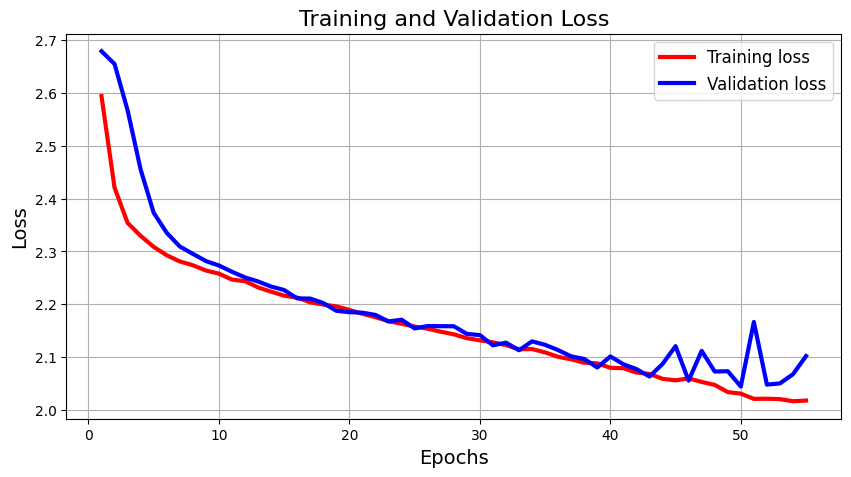

In [120]:
epochs = range(1, len(train_losses) + 1)

# Plotting the loss curves
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training loss', color='r', linewidth=3.0)
plt.plot(epochs, val_losses, label='Validation loss', color='b', linewidth=3.0)

# Adding titles and labels
plt.title('Training and Validation Loss', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)

# Display the plot
plt.grid(True)
plt.show()

# Model Evaluation

Test batch size: 12


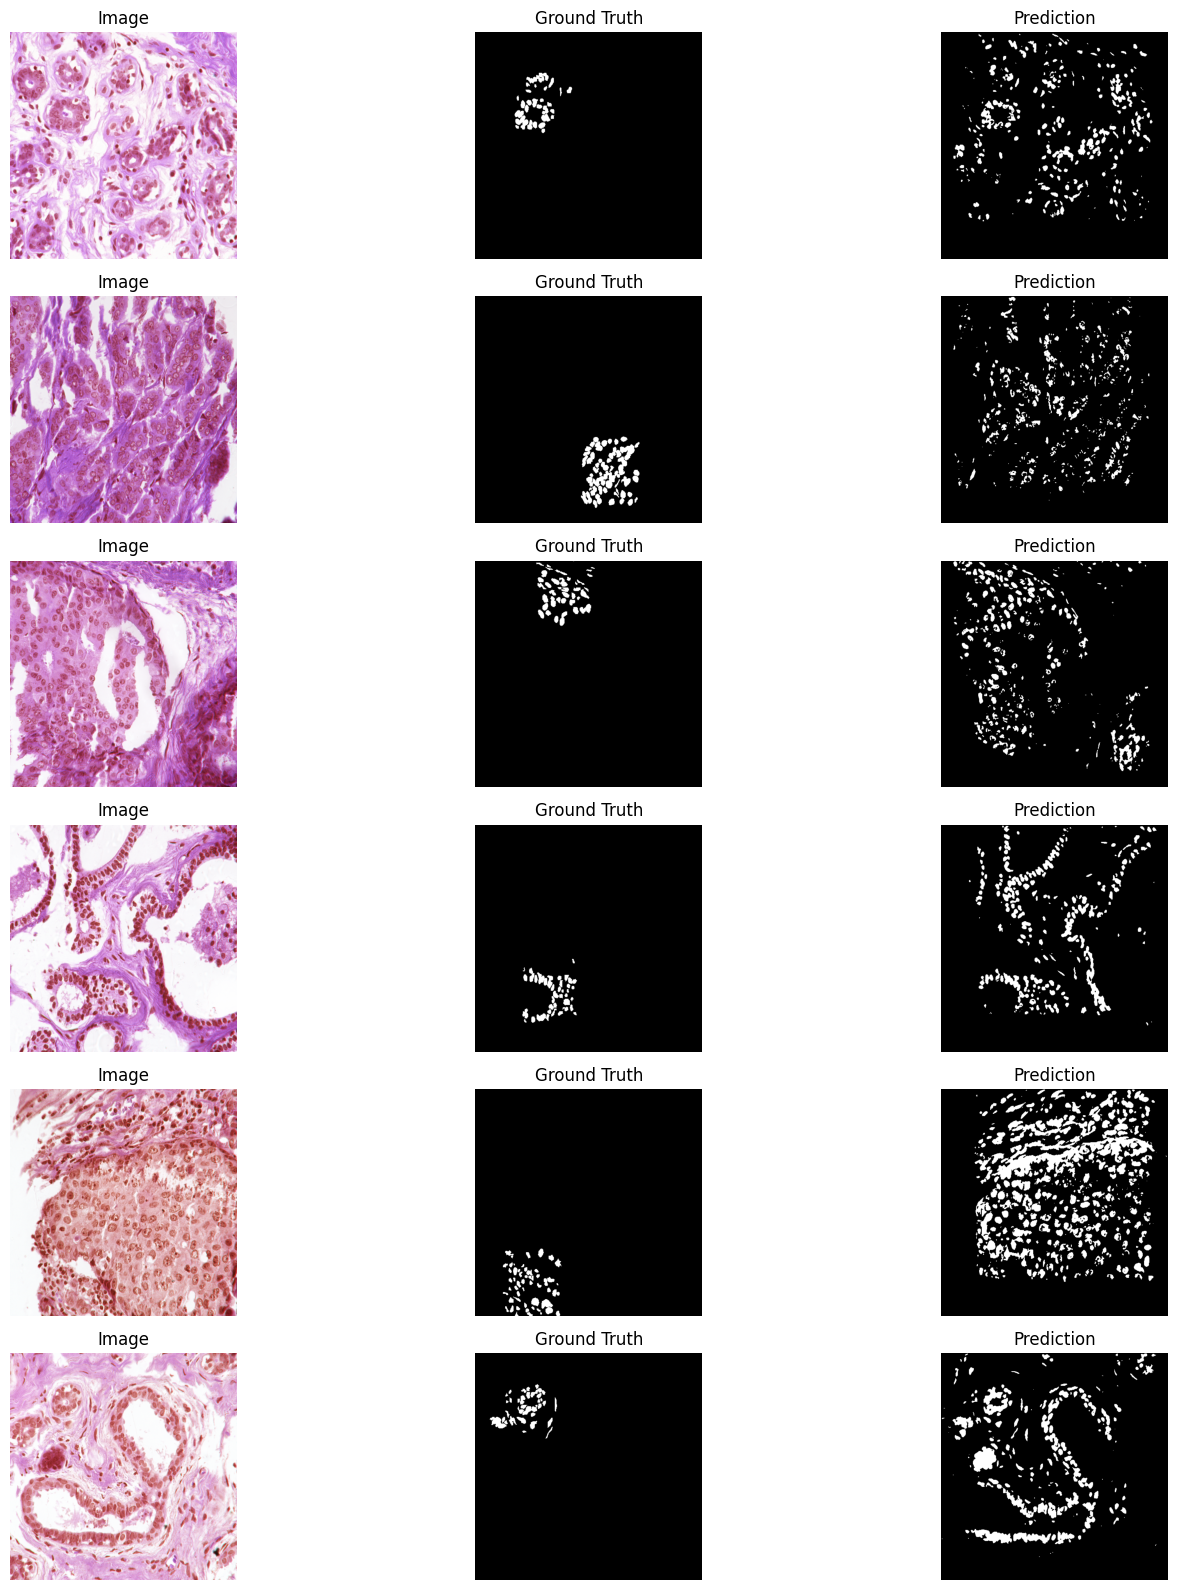

In [128]:
THRESHOLD =  0.5

# load_checkpoint(torch.load("my_checkpoint.pth.tar"), model)

val_transform = A.Compose(
    [
      A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
      A.Normalize(
          mean=[0.0, 0.0, 0.0],
          std=[1.0, 1.0, 1.0],
          max_pixel_value=255.0,
      ),
      ToTensorV2(),
    ],
)

val_dataset = SegmentationDataset(val_paths, transform=val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

print(f"Test batch size: {len(val_dataloader)}")

model.eval()
fig, ax = plt.subplots(6, 3, figsize=(16, 16))

with torch.no_grad():
  for batch_idx, (data, targets) in enumerate(val_dataloader):
    if batch_idx >= 6: # Process only the first 5 batches
      break

    data = data.to(device=DEVICE)
    targets = targets.float().unsqueeze(1).to(device=DEVICE)

    predictions = model(data)
    predictions = torch.sigmoid(predictions)
    predictions = (predictions >= THRESHOLD).float()
    # predictions[predictions >= 0.5] = 1
    # predictions[predictions < 0.5] = 0

    ax[batch_idx, 0].imshow(data[0].permute(1, 2, 0).cpu().numpy())
    ax[batch_idx, 0].set_title("Image")
    ax[batch_idx, 0].set_axis_off()

    ax[batch_idx, 1].imshow(targets[0].cpu().numpy().squeeze(), cmap="gray")
    ax[batch_idx, 1].set_title("Ground Truth")
    ax[batch_idx, 1].set_axis_off()

    ax[batch_idx, 2].imshow(predictions[0].cpu().numpy().squeeze(), cmap="gray")
    ax[batch_idx, 2].set_title("Prediction")
    ax[batch_idx, 2].set_axis_off()

  plt.tight_layout()
  plt.show()

In [122]:
def calculate_tp_tn_fp_fn(y_true, y_pred):
    """
    Calculates True Positives, True Negatives, False Positives, and False Negatives.
    y_true: (N, H, W) or (N, 1, H, W) binary masks (ground truth)
    y_pred: (N, H, W) or (N, 1, H, W) binary masks (predictions)
    """
    y_true_flat = y_true.view(-1)
    y_pred_flat = y_pred.view(-1)

    # Ensure tensors are boolean or 0/1 for logical operations
    y_true_bool = y_true_flat.bool()
    y_pred_bool = y_pred_flat.bool()

    TP = torch.sum(y_true_bool & y_pred_bool).float()
    TN = torch.sum(~y_true_bool & ~y_pred_bool).float()
    FP = torch.sum(~y_true_bool & y_pred_bool).float()
    FN = torch.sum(y_true_bool & ~y_pred_bool).float()

    return TP, TN, FP, FN

def accuracy_metric(TP, TN, FP, FN):
    """
    Calculates accuracy.
    """
    total_pixels = TP + TN + FP + FN
    if total_pixels == 0:
        return torch.tensor(0.0)
    return (TP + TN) / total_pixels

def precision_metric(TP, FP, smooth=1e-8):
    """
    Calculates precision. Handles division by zero.
    """
    denominator = TP + FP
    if denominator == 0:
        return torch.tensor(0.0)
    return TP / denominator

def recall_metric(TP, FN, smooth=1e-8):
    """
    Calculates recall. Handles division by zero.
    """
    denominator = TP + FN
    if denominator == 0:
        return torch.tensor(0.0)
    return TP / denominator

def f1_score_metric(precision, recall, smooth=1e-8):
    """
    Calculates F1 score. Handles division by zero.
    """
    denominator = precision + recall
    if denominator == 0:
        return torch.tensor(0.0)
    return 2 * (precision * recall) / denominator

In [116]:
def model_evaluation(model, test_dataloader, device, threshold=0.5):
  # Set the model to evaluation mode
  model.eval()
  # Accumulators for metrics
  total_tp, total_tn, total_fp, total_fn = 0.0, 0.0, 0.0, 0.0
  total_dice_score = 0.0
  total_iou_score = 0.0

  print("Starting model evaluation...")
  with torch.no_grad():
    for batch_idx, (data, targets) in enumerate(tqdm(test_dataloader, desc="Evaluating")):
      data = data.to(device=device)
      targets = targets.float().unsqueeze(1).to(device=device)

      # Make predictions and convert to binary masks
      predictions = torch.sigmoid(model(data))
      predictions = (predictions > threshold).float()

      # Ensure targets are also binary
      targets_binary = (targets > threshold).float()

      # Calculate TP, TN, FP, FN for current batch
      TP, TN, FP, FN = calculate_tp_tn_fp_fn(targets_binary, predictions)
      total_tp += TP
      total_tn += TN
      total_fp += FP
      total_fn += FN

      # Calculate Dice score for current batch
      dice = (2 * (predictions * targets_binary).sum(dim=(2,3)) + 1e-8) / (
          predictions.sum(dim=(2,3)) + targets_binary.sum(dim=(2,3)) + 1e-8
      )
      total_dice_score += dice.mean().item()

      # Calculate IoU for current batch
      iou = iou_metric(targets_binary, predictions)
      total_iou_score += iou.mean().item()

  # Aggregate metrics over all batches
  num_samples = len(test_dataloader)

  # Accuracy
  overall_accuracy = accuracy_metric(total_tp, total_tn, total_fp, total_fn)

  # Precision
  overall_precision = precision_metric(total_tp, total_fp)

  # Recall
  overall_recall = recall_metric(total_tp, total_fn)

  # F1 Score
  overall_f1_score = f1_score_metric(overall_precision, overall_recall)

  # Dice Coefficient (mean over all batches)
  overall_dice_coefficient = total_dice_score / num_samples

  # IoU (mean over all batches)
  overall_iou = total_iou_score / num_samples

  print("\n--- Model Evaluation Results ---")
  print(f"Overall Accuracy: {overall_accuracy:.4f}")
  print(f"Overall Precision: {overall_precision:.4f}")
  print(f"Overall Recall: {overall_recall:.4f}")
  print(f"Overall F1 Score: {overall_f1_score:.4f}")
  print(f"Overall Dice Coefficient: {overall_dice_coefficient:.4f}")
  print(f"Overall IoU: {overall_iou:.4f}")
  print("--------------------------------")

  model.train()
  return {
      "accuracy": overall_accuracy.item(),
      "precision": overall_precision.item(),
      "recall": overall_recall.item(),
      "f1_score": overall_f1_score.item(),
      "dice_coefficient": overall_dice_coefficient,
      "iou": overall_iou
  }



In [117]:
metrics = model_evaluation(model, val_dataloader, DEVICE, 0.5)

Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.24it/s]


--- Model Evaluation Results ---
Overall Accuracy: 0.9197
Overall Precision: 0.1264
Overall Recall: 0.6081
Overall F1 Score: 0.2092
Overall Dice Coefficient: 0.2383
Overall IoU: 0.1409
--------------------------------


In [118]:
def find_best_threshold(
    model,
    test_dataloader,
    device,
    thresholds=np.arange(0.1, 0.9, 0.05),
    optimize_for="dice"  # "dice", "iou", or "f1"
):
    best_threshold = 0.5
    best_score = -1
    all_results = []

    for th in thresholds:
        metrics = model_evaluation(
            model,
            test_dataloader,
            device=device,
            threshold=th
        )

        score = metrics[
            "dice_coefficient" if optimize_for == "dice"
            else "iou" if optimize_for == "iou"
            else "f1_score"
        ]

        all_results.append((th, score))

        print(f"Threshold {th:.2f} -> {optimize_for.upper()}: {score:.4f}")

        if score > best_score:
            best_score = score
            best_threshold = th

    print("\n==============================")
    print(f"✅ Best Threshold: {best_threshold:.2f}")
    print(f"✅ Best {optimize_for.upper()}: {best_score:.4f}")
    print("==============================")

    return best_threshold, all_results

In [119]:
best_threshold, results = find_best_threshold(model, val_dataloader, DEVICE, optimize_for="dice")

Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.72it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.4981
Overall Precision: 0.0334
Overall Recall: 0.9913
Overall F1 Score: 0.0645
Overall Dice Coefficient: 0.0671
Overall IoU: 0.0348
--------------------------------
Threshold 0.10 -> DICE: 0.0671
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.73it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.8208
Overall Precision: 0.0806
Overall Recall: 0.8895
Overall F1 Score: 0.1478
Overall Dice Coefficient: 0.1752
Overall IoU: 0.0980
--------------------------------
Threshold 0.15 -> DICE: 0.1752
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.63it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.8632
Overall Precision: 0.0946
Overall Recall: 0.7971
Overall F1 Score: 0.1691
Overall Dice Coefficient: 0.2006
Overall IoU: 0.1143
--------------------------------
Threshold 0.20 -> DICE: 0.2006
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.48it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.8817
Overall Precision: 0.1033
Overall Recall: 0.7511
Overall F1 Score: 0.1816
Overall Dice Coefficient: 0.2141
Overall IoU: 0.1233
--------------------------------
Threshold 0.25 -> DICE: 0.2141
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.02it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.8933
Overall Precision: 0.1096
Overall Recall: 0.7175
Overall F1 Score: 0.1902
Overall Dice Coefficient: 0.2227
Overall IoU: 0.1293
--------------------------------
Threshold 0.30 -> DICE: 0.2227
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.25it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.9016
Overall Precision: 0.1147
Overall Recall: 0.6898
Overall F1 Score: 0.1967
Overall Dice Coefficient: 0.2288
Overall IoU: 0.1336
--------------------------------
Threshold 0.35 -> DICE: 0.2288
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.53it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.9083
Overall Precision: 0.1190
Overall Recall: 0.6634
Overall F1 Score: 0.2018
Overall Dice Coefficient: 0.2333
Overall IoU: 0.1369
--------------------------------
Threshold 0.40 -> DICE: 0.2333
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.47it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.9142
Overall Precision: 0.1227
Overall Recall: 0.6361
Overall F1 Score: 0.2057
Overall Dice Coefficient: 0.2362
Overall IoU: 0.1391
--------------------------------
Threshold 0.45 -> DICE: 0.2362
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.57it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.9197
Overall Precision: 0.1264
Overall Recall: 0.6081
Overall F1 Score: 0.2092
Overall Dice Coefficient: 0.2383
Overall IoU: 0.1409
--------------------------------
Threshold 0.50 -> DICE: 0.2383
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.42it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.9255
Overall Precision: 0.1304
Overall Recall: 0.5756
Overall F1 Score: 0.2127
Overall Dice Coefficient: 0.2398
Overall IoU: 0.1423
--------------------------------
Threshold 0.55 -> DICE: 0.2398
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.48it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.9338
Overall Precision: 0.1371
Overall Recall: 0.5269
Overall F1 Score: 0.2176
Overall Dice Coefficient: 0.2412
Overall IoU: 0.1439
--------------------------------
Threshold 0.60 -> DICE: 0.2412
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.36it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.9476
Overall Precision: 0.1509
Overall Recall: 0.4325
Overall F1 Score: 0.2238
Overall Dice Coefficient: 0.2360
Overall IoU: 0.1416
--------------------------------
Threshold 0.65 -> DICE: 0.2360
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.32it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.9617
Overall Precision: 0.1710
Overall Recall: 0.3104
Overall F1 Score: 0.2205
Overall Dice Coefficient: 0.2118
Overall IoU: 0.1268
--------------------------------
Threshold 0.70 -> DICE: 0.2118
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.15it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.9728
Overall Precision: 0.1953
Overall Recall: 0.1795
Overall F1 Score: 0.1870
Overall Dice Coefficient: 0.1517
Overall IoU: 0.0910
--------------------------------
Threshold 0.75 -> DICE: 0.1517
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  8.90it/s]



--- Model Evaluation Results ---
Overall Accuracy: 0.9807
Overall Precision: 0.2571
Overall Recall: 0.0557
Overall F1 Score: 0.0916
Overall Dice Coefficient: 0.0670
Overall IoU: 0.0386
--------------------------------
Threshold 0.80 -> DICE: 0.0670
Starting model evaluation...


Evaluating: 100%|██████████| 12/12 [00:01<00:00,  9.00it/s]


--- Model Evaluation Results ---
Overall Accuracy: 0.9825
Overall Precision: 0.0000
Overall Recall: 0.0000
Overall F1 Score: 0.0000
Overall Dice Coefficient: 0.0000
Overall IoU: 0.0000
--------------------------------
Threshold 0.85 -> DICE: 0.0000

✅ Best Threshold: 0.60
✅ Best DICE: 0.2412


In [69]:
best_threshold

np.float64(0.5000000000000001)